## Sentiment Analysis using Twitter Data by SVM

In [82]:
import tweepy
import nltk

### Downloading all the necessary data for cleaning the tweets from NLTK function

In [83]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jithin Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Include all necessary headers & libraries

In [109]:
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk import classify 
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
import re, string, random
import warnings
warnings.filterwarnings('ignore')
from itertools import chain
from sklearn.metrics import confusion_matrix
import seaborn as sn

### Downloading twitter data from NLTK corpus

In [85]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

In [86]:
#Tokeninzing the tweets using the NLTK's tokenized functions
print(tweet_tokens[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


### Data pre-processing: removing links, special characters and stopwords

In [87]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []
    words = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    
    for text in cleaned_tokens:  
        soup = BeautifulSoup(text, 'html5lib')
        souped = soup.get_text()
        stripped = re.sub(combined_pat, '', souped)
        try:
            clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
        except:
            clean = stripped
        letters_only = re.sub("[^a-zA-Z]", " ", clean)
        lower_case = letters_only.lower()
        words.append(tok.tokenize(lower_case))
        final_tokens = [j for i in words for j in i]
    
    return final_tokens 

### Printing the tokens after cleaning

In [88]:
print(remove_noise(tweet_tokens[0], stop_words))

['followfriday', 'top', 'engage', 'member', 'community', 'week']


### Adding all the cleaned tokens of the tweets into a list of list

In [89]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [90]:
#Printing the cleaned tokenized list
print(positive_cleaned_tokens_list[0:15])


[['followfriday', 'top', 'engage', 'member', 'community', 'week'], ['hey', 'james', 'odd', 'please', 'call', 'contact', 'centre', 'able', 'assist', 'many', 'thanks'], ['listen', 'last', 'night', 'bleed', 'amazing', 'track', 'scotland'], ['congrats'], ['yeaaaah', 'yippppy', 'accnt', 'verify', 'rqst', 'succeed', 'get', 'blue', 'tick', 'mark', 'fb', 'profile', 'day'], ['one', 'irresistible', 'flipkartfashionfriday'], ['like', 'keep', 'lovely', 'customer', 'wait', 'long', 'hope', 'enjoy', 'happy', 'friday', 'lwwf'], ['second', 'thought', 'enough', 'time', 'dd', 'new', 'short', 'enter', 'system', 'sheep', 'must', 'buy'], ['jgh', 'go', 'bayan', 'd', 'bye'], ['act', 'mischievousness', 'call', 'etl', 'layer', 'in', 'house', 'warehouse', 'app', 'katamari', 'well', 'name', 'imply', 'p'], ['followfriday', 'top', 'influencers', 'community', 'week'], ['love', 'big', 'juicy', 'selfies'], ['follow', 'follow', 'u', 'back'], ['perfect', 'already', 'know', 'what', 's', 'wait'], ['great', 'new', 'opportu

### Creating dataset for SVM

In [91]:
positive_dataset = [(tweet_dict, "Positive") for tweet_dict in positive_cleaned_tokens_list]

negative_dataset = [(tweet_dict, "Negative") for tweet_dict in negative_cleaned_tokens_list]

data = positive_dataset + negative_dataset

random.shuffle(data)

#Dataset is split into 70% training data and 30% testing data
train = data[:7000]
test = data[7000:]

print("Length of training dataset:",len(train))
print("Length of testing dataset:",len(test))

print("Train data:",train[0:5])
print("\nTest data:",test[0:5])

Length of training dataset: 7000
Length of testing dataset: 3000
Train data: [(['like', 'dog'], 'Negative'), (['thaaanks', 'december', 'puhon'], 'Positive'), (['happy', 'birthday', 'we', 're', 'positive', 'full', 'cake'], 'Positive'), (['miss', 'infinite'], 'Negative'), (['followed', 'thanks', 'please', 'followed'], 'Negative')]

Test data: [(['followfriday', 'top', 'support', 'community', 'week'], 'Positive'), (['anytime'], 'Positive'), (['kinda', 'smug', 'know', 'stuff', 'marrickville', 'public', 'ten', 'year', 'ago'], 'Positive'), (['school', 'monday', 'wanna', 'meet', 'new', 'people'], 'Negative'), (['poorly', 'bed', 'netflix', 'today'], 'Negative')]


### Support Vector Machines (SVM) Implementation

### Data Analysis using Pandas

In [92]:
train_data = pd.DataFrame(train,columns = ['content', 'label'])
test_data = pd.DataFrame(test, columns = ['content', 'label'])

#Obtained data is converted into .csv
train_data.to_csv("/train.csv")
test_data.to_csv("/test.csv")

In [93]:
#Read .csv as pandas dataframe
trainn=pd.read_csv("/train.csv")
testt=pd.read_csv("/test.csv")
train=trainn.drop(columns=['Unnamed: 0'])
test=testt.drop(columns=['Unnamed: 0'])

print(train.shape)
print(test.shape)

(7000, 2)
(3000, 2)


In [94]:
#Printing train dataframe
train.head(15)

,content,label
0,"['like', 'dog']",Negative
1,"['thaaanks', 'december', 'puhon']",Positive
2,"['happy', 'birthday', 'we', 're', 'positive', ...",Positive
3,"['miss', 'infinite']",Negative
4,"['followed', 'thanks', 'please', 'followed']",Negative
5,"['can', 't', 'post', 'message']",Negative
6,"['bring', 'boatbound', 'brings', 'luxury', 'ya...",Positive
7,"['listen', 'live']",Positive
8,"['wish', 'could', 'dm', 'cute', 'thing', 'pref...",Negative
9,['kill'],Positive


In [95]:
#Printing test dataframe
test.head(15)

,content,label
0,"['followfriday', 'top', 'support', 'community'...",Positive
1,['anytime'],Positive
2,"['kinda', 'smug', 'know', 'stuff', 'marrickvil...",Positive
3,"['school', 'monday', 'wanna', 'meet', 'new', '...",Negative
4,"['poorly', 'bed', 'netflix', 'today']",Negative
5,"['hi', 'j', 'upgrade', 't', 'mobile', 'orange'...",Positive
6,['mashaket'],Negative
7,"['favorite', 'apple', 'sauce']",Positive
8,"['new', 'sandra', 'bland', 'footage', 'really'...",Negative
9,"['serious', 'note', 'reply', 'dm', 'send', 'ha...",Negative


### Vectorizing the data using vectorizer for SVM

In [96]:
vectorizer = TfidfVectorizer(sublinear_tf = True, use_idf = True)

#Train and test data are converted into vectors for training SVM model
train_vectors = vectorizer.fit_transform(train['content'])
test_vectors = vectorizer.transform(test['content'])

### Training the SVM classifier

In [97]:
#Training
#Using Linear SVC
classifier_svm = svm.SVC(kernel='linear')
classifier_svm.fit(train_vectors, train['label'])
prediction_svm = classifier_svm.predict(test_vectors)

### Evaluation

In [98]:
classification_report = classification_report(test['label'], prediction_svm, output_dict=True)

print('Positive: ', classification_report['Positive'])
print('Negative: ', classification_report['Negative'])
print("\nAccuracy is ", accuracy_score(prediction_svm, test['label'])*100)

Positive:  {'precision': 0.775886524822695, 'recall': 0.7211601845748187, 'f1-score': 0.747523061154766, 'support': 1517}
Negative:  {'precision': 0.7339622641509433, 'recall': 0.786918408631153, 'f1-score': 0.7595183859420761, 'support': 1483}

Accuracy is  75.36666666666667


### Collecting data from twitter using tweetpy that serves as the input data

In [116]:
import tweepy,csv,re,json
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

tweetText = []
consumer_key='vn4Bchk1jcxRQY4Hlea4dmpkS'
consumer_secret ='9aN4JfIyM9oChyqNjVx68OdFahh68HPYcyzzD7jcIFDQ26WBWB'
access_token = '1267422786479423494-zHorrWgAMF2kFGhBZSp62qLLOrJVcz'
access_token_secret ='fVN4HX1bVllOEHS9EDsSNCOmg2dUzsJwGRD06IZHz3oqQ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


# input for term to be searched and how many tweets to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

# searching for tweets
tweets = tweepy.Cursor(api.search, q=searchTerm, lang = "en").items(NoOfTerms)


for tweet in tweets:
    tweetText.append(tweet.text)
    
print("\nRaw tweets:",tweetText)

final_tweets = []

for i in tweetText:
    final_tweets.append(remove_noise(word_tokenize(i)))

joined_strings=[]
for tweet in final_tweets:
    joined_strings.append((" ").join(tweet))

count=1
for i in joined_strings:
    input_vector = vectorizer.transform([i])
    predicted_sentiment=classifier_svm.predict(input_vector)
    print("\nPredicted Sentiment for tweet {0}:{1}".format(count,predicted_sentiment))
    count+=1
    

Enter Keyword/Tag to search about: donald trump
Enter how many tweets to search: 5

Raw tweets: ['RT @jeremymbarr: Mark Cuban to Sean Hannity: "Donald Trump can\'t answer your questions. You and every Fox News interviewer gives him the ea…', 'RT @davidplouffe: COVID-19 may have originated in China. The deadly pathogen found it’s perfect host in Donald J Trump.', 'RT @sara_hi_c: Donald trump says if we stop testing we won’t have cases ... so if I stop looking at my bills I don’t have them anymore ? 👀', 'RT @CNN: Most Presidents would try to stop the United States from barreling toward disaster. But Donald Trump has nothing to say and no ans…', 'RT @PamKeithFL: I call on Donald Trump to resign his presidency immediately.']

Predicted Sentiment for tweet 1:['Positive']

Predicted Sentiment for tweet 2:['Positive']

Predicted Sentiment for tweet 3:['Positive']

Predicted Sentiment for tweet 4:['Negative']

Predicted Sentiment for tweet 5:['Negative']


### Plotting the Confusion Matrix

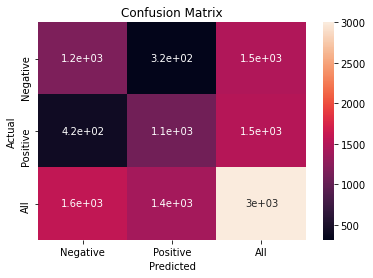

In [110]:
cm=confusion_matrix(test['label'],prediction_svm)
df_confusion = pd.crosstab(test['label'],prediction_svm,rownames=['Actual'], colnames=['Predicted'], margins=True)
#print(df_confusion)
plt.title("Confusion Matrix")
sn.heatmap(df_confusion,annot=True)
